In [1]:
import os
import numpy as np
import pandas as pd

import copy

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline

from skimage import measure

import impdar
from impdar.lib import load
from impdar.lib import plot
from impdar.lib import process

## Loading Data

In [2]:
#files on disk
green_mat_file = '../data/nline5.mat'

#load in data
dat = load.load('mat', green_mat_file)[0]

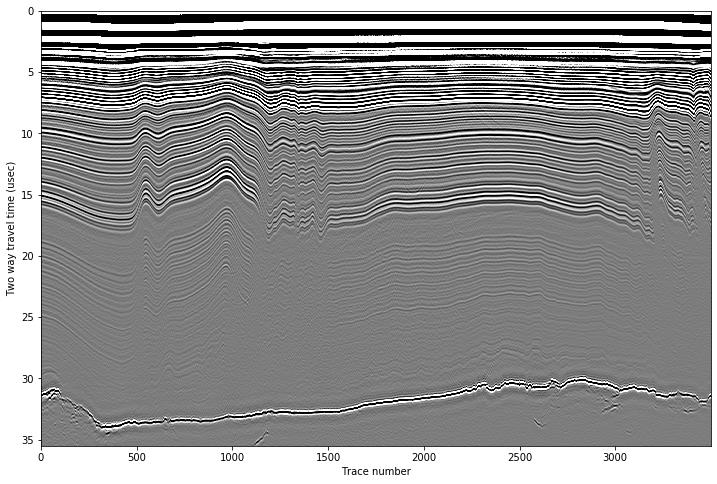

In [3]:
#visualize the data
plot.plot_radargram(dat)
plt.show()

## Contouring

In [4]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [5]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [6]:
#positive contours
for contour in pos:
    c_pos.append(contour)
print('Done!\n')

#negative contours
for contour in neg:
    c_neg.append(contour)
print('Done!\n') 

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
print('Done!\n')
    
for contour in neg:
    c_length_neg.append(len(contour))
print('Done!\n')

Done!

Done!

Done!

Done!



In [7]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos = list(np.where(np.array(c_length_pos) > 500)[0])
long_contours_neg = list(np.where(np.array(c_length_neg) > 500)[0])

38
44400
298
30373


In [29]:
#isolate some contours
last_long_idx = long_contours_neg[-30:]
last_long_contours = [neg[idx] for idx in last_long_idx]

### find end points

## I need to break apart this whole method into its constituent parts

#### Missing `find_contours()` method, for finding the actual contours

In [30]:
def find_contour_points(contour, argx_list):
    #find left- and right-most x point on contour
    argx1 = np.argmin(contour[:, 1])
    argx2 = np.argmax(contour[:, 1])
    argx_list.append([argx1, argx2])
    
    #find unique set of x values for each contour
    uniquex = (list(set([int(x) for x in contour[:, 1]])))
    
    #get rid of x values that we don't have contour data for
    saved_points = []
    delete = []

    for x in uniquex:
        wherex = np.where(contour[:, 1] == x)[0]
        #if we don't have at least two values, get rid of that point
        if len(wherex) < 2:
            delete.append(x)
        else:
            #sometimes there are more than two points, we want the last two
            if len(wherex) > 2:
                saved_points.append(wherex[1:3])
            else:
                saved_points.append(wherex)
    
    #delete values that we don't have enough data for
    uniquex = [x for x in uniquex if x not in delete]
    
    return uniquex, saved_points

In [31]:
def find_ridge_points(to_delete, uniquex, saved_points, data, ridge_points):
    
    for i, point in enumerate(saved_points):
        if(len(point == 2)):
            idx1 = point[0]
            idx2 = point[1]
        elif(len(point > 2)):
            idx1 = point[1]
            idx2 = point[2]
        else:
            raise ValueException("You need to have at least two matching y-values.")

        x = uniquex[i]

        y1 = int(contour[idx1, 0])
        y2 = int(contour[idx2, 0])

        #check to see whether *both* points lie in a ridge or trough (for positive and negative contours)
        #only contains positive numbers: ridge --> search for troughs later
        if np.logical_and(data[y1, x] > 0, data[y2, x] > 0):
            if len(data[y2:y1, x]) == 0:
                ridge_points.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
            else:
                ridge_points.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
            
        #only contains negative numbers: trough --> search for ridges later
        elif np.logical_and(data[y1, x] < 0, data[y2, x] < 0):
            if len(data[y2:y1, x]) == 0:
                ridge_points.append(np.where(data[:, x] == np.min(data[y1:y2, x]))[0])
            else:
                ridge_points.append(np.where(data[:, x] == np.min(data[y2:y1, x]))[0])
            
        #else the points contain both a positive and negative value, we need to skip over that
        #if we skip over that point, we need to delete it from uniquex and saved_points
        else:
            to_delete.append(x)
      
    return [elem[0] for elem in ridge_points], to_delete

In [32]:
def find_troughs(uniquex, ridge_points, data):
    maxrows, maxcols = np.shape(data)
    
    top, bottom = [], []
    temptop_idx, tempbottom_idx = [], []
    temptop_points, tempbottom_points = [], []

    for i, point in enumerate(uniquex):
        row = ridge_points[i]
        col = point

        #if the point holds a positive value, then we want to
        #find the troughs on either side of it
        if data[row, col] < 0:
            #look for top contour
            for j in range(row, maxrows):
                #enter the ridge
                if (data[j, col] >= 0):
                    temptop_idx.append(j)
                    temptop_points.append(data[j, col])

                    #enterting this if statement would signify leaving the ridge
                    if data[j+1, col] < 0:
                        #find the minimum in that column of the trough
                        ridge_top_max = np.argmin(temptop_points)
                        top.append(temptop_idx[ridge_top_max])

                        #reset these to empty for the next column
                        temptop_idx, temptop_points = [], []
                        break

            #look for bottom contour
            for k in range(0, row):
                #enter the trough
                if (data[row-k, col] >= 0):
                    tempbottom_idx.append(row-k)
                    tempbottom_points.append(data[row-k, col])

                    #enterting this if statement would signify leaving the trough
                    if data[row-k-1, col] > 0:
                        #find the minimum in that column of the trough
                        ridge_bottom_max = np.argmin(tempbottom_points)
                        bottom.append(tempbottom_idx[ridge_bottom_max])

                        #reset these to empty for the next column
                        tempbottom_idx, tempbottom_points = [], []
                        break

    return top, bottom

Eventually, this &#9660;&#9660;&#9660;&#9660; will need to be be its own method.

In [33]:
#save lists
argx_list = []
uniquex_list = []
saved_points_list = []

ridge_points_list = []
top, bottom = [], []
top_list, bottom_list = [], []

In [34]:
for i, contour in enumerate(last_long_contours):
    #get shape of data
    maxrows, maxcols = np.shape(data)
    
    #find x values for contour and where along that contour that x value occurs (aka, y values)
    uniquex, saved_points = find_contour_points(contour, argx_list)
    saved_points_list.append(saved_points)

    #find y values and ridge points for each contour
    ridge_points = []
    to_deletex = []
    
    ridge, to_deletex = find_ridge_points(to_deletex, uniquex, saved_points, data, ridge_points)
    ridge_points_list.append(ridge)
    
    #now we need to delete the values that we couldn't find a ridge/trough value from
    #now they should be the same length
    uniquex = [x for x in uniquex if x not in to_deletex]    
    uniquex_list.append(uniquex)
        
    #find top and bottom troughs/peaks
    top, bottom = find_troughs(uniquex, ridge, data)
    top_list.append(top)
    bottom_list.append(bottom)
    
    print(i, argx_list[i], len(uniquex_list[i]), len(saved_points_list[i]), len(ridge_points_list[i]))

0 [1836, 9] 679 679 679
1 [304, 6] 111 111 111
2 [1677, 833] 219 219 219
3 [539, 7] 221 221 221
4 [414, 5] 168 168 168
5 [819, 3] 290 290 290
6 [665, 3] 219 219 219
7 [274, 4] 108 108 108
8 [272, 6] 128 128 128
9 [0, 754] 270 322 270
10 [1716, 5] 480 751 480
11 [915, 436] 109 177 109
12 [678, 229] 130 130 130
13 [1077, 497] 84 214 84
14 [574, 184] 149 149 149
15 [2180, 823] 279 478 279
16 [5661, 2809] 1095 1675 1095
17 [860, 307] 128 216 128
18 [638, 175] 52 52 52
19 [1284, 535] 152 203 152
20 [903, 442] 152 165 152
21 [1356, 441] 261 450 261
22 [927, 428] 112 115 112
23 [539, 249] 124 124 124
24 [693, 317] 204 204 204
25 [890, 334] 281 281 281
26 [412, 5] 104 109 104
27 [676, 271] 78 78 78
28 [1547, 703] 293 383 293
29 [622, 297] 77 77 77


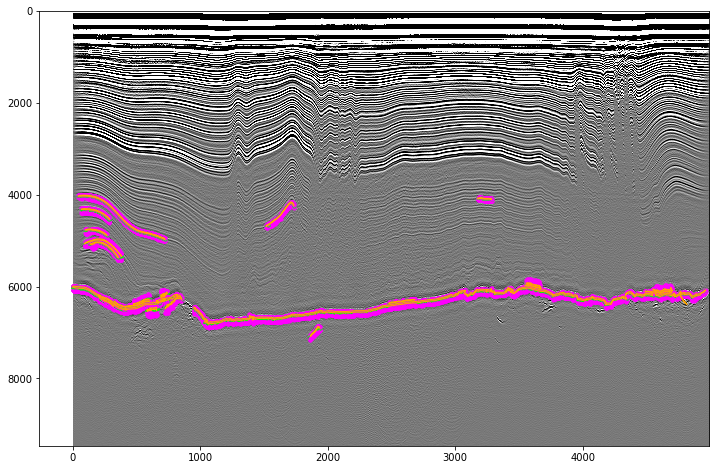

In [35]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

#plot grid
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(last_long_contours):
    #plot contours
    ax.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)

    #plot ridge points
    ridge = ridge_points_list[i]
    uniqx = uniquex_list[i]
    top_ = top_list[i]
    bottom_ = bottom_list[i]
        
    for j, x in enumerate(uniqx):
        t = top_[j]
        r = ridge[j]
        b = bottom_[j]
        
        ax.scatter(x, t, color='magenta', marker='o', s=10)
        ax.scatter(x, r, color='lime', marker='o', s=10)
        ax.scatter(x, b, color='magenta', marker='o', s=10)
        
plt.show()

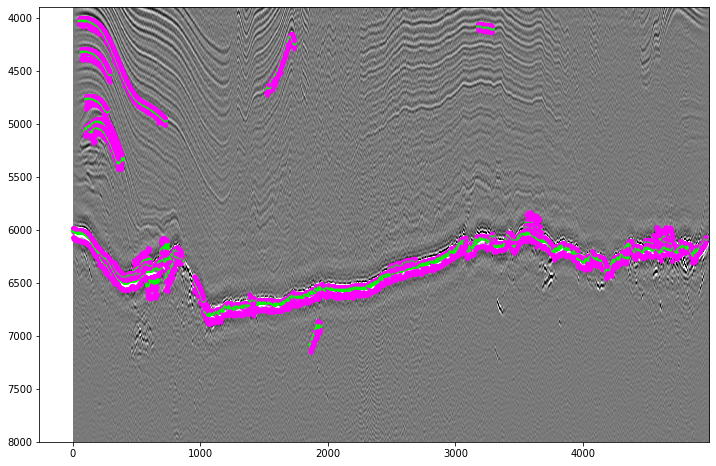

In [37]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

#plot grid
ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i in range(len(ridge_points_list)):
    #plot ridge points
    ridge = ridge_points_list[i]
    uniqx = uniquex_list[i]
    top_ = top_list[i]
    bottom_ = bottom_list[i]
    
    for j, x in enumerate(uniqx):
        t = top_[j]
        r = ridge[j]
        b = bottom_[j]
        
        ax.scatter(x, t, color='magenta', marker='o', s=10)
        ax.scatter(x, r, color='lime', marker='o', s=10)
        ax.scatter(x, b, color='magenta', marker='o', s=10)
        
ax.set_ylim(8000, 3900)
        
plt.show()

<IPython.core.display.Javascript object>


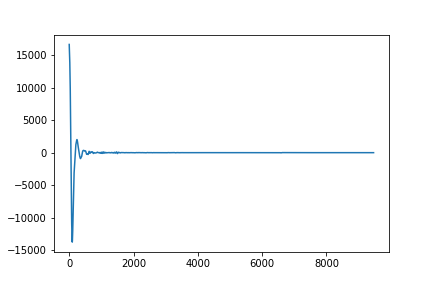

In [42]:
%matplotlib notebook
plt.plot(data[:, 1000])
plt.show()

<IPython.core.display.Javascript object>


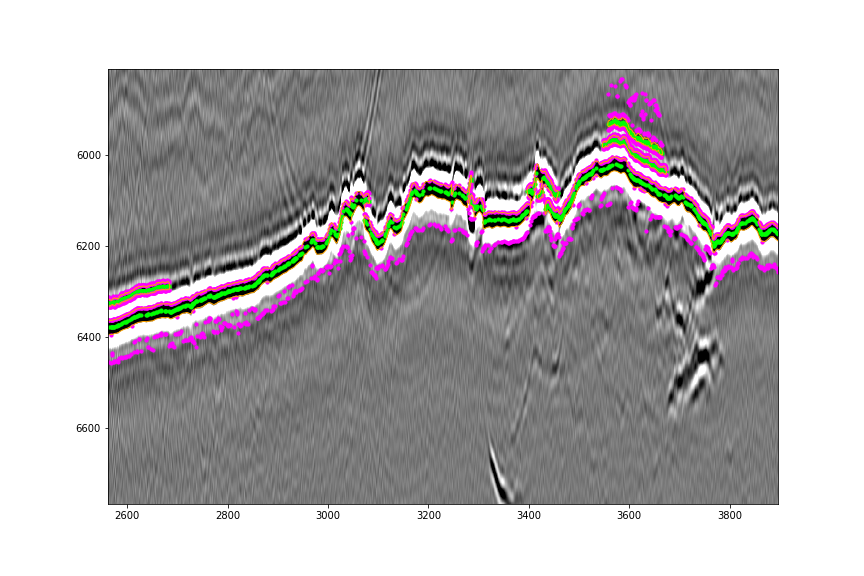

In [43]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(12, 8))

#plot grid
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(last_long_contours):
    #plot contours
    ax.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)

    #plot ridge points
    ridge = ridge_points_list[i]
    uniqx = uniquex_list[i]
    top_ = top_list[i]
    bottom_ = bottom_list[i]
    
    for j, x in enumerate(uniqx):
        r = ridge[j]
        t = top_[j]
        b = bottom_[j]
        
        ax.scatter(x, r, color='lime', marker='o', s=10)
        ax.scatter(x, t, color='magenta', marker='o', s=10)
        ax.scatter(x, b, color='magenta', marker='o', s=10)

plt.show()

I need to look more closely at the find_troughs() method.